In [ ]:
!pip install numpy scipy matplotlib shapely svgpathtools opencv-python-headless scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 6.6 MB/s eta 0:00:00


Data preview:
      0    1          2          3
0  0.0  0.0  39.202999  67.878998
1  0.0  0.0  39.734318  68.487076
2  0.0  0.0  40.277573  69.059059
3  0.0  0.0  40.832302  69.596413
4  0.0  0.0  41.398037  70.100624
Columns in CSV file: [0, 1, 2, 3]


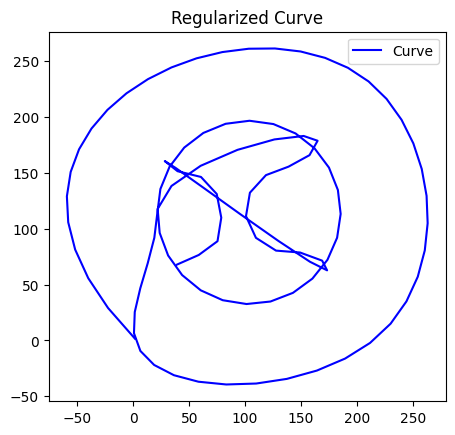

Is Straight Line: True
Is Circle: False
Is Ellipse: False
Is Rectangle: False
Is Regular Polygon (6 sides): False
Is Star Shape: True


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
from svgpathtools import Path, CubicBezier, wsvg

def read_points_from_csv(file_path):
    df = pd.read_csv(file_path, header=None)

    print("Data preview:\n", df.head())
    print("Columns in CSV file:", df.columns.tolist())

    x_col = df.columns[-2]
    y_col = df.columns[-1]

    points = [(row[x_col], row[y_col]) for index, row in df.iterrows()]
    return points

def fit_bezier_curve(points, num_points=100):
    points = np.array(points)
    if len(points) < 4:
        raise ValueError("Not enough points to fit a Bezier curve")

    tck, u = splprep([points[:, 0], points[:, 1]], s=0, k=3)
    u_fine = np.linspace(0, 1, num_points)
    spline_points = splev(u_fine, tck)
    return list(zip(spline_points[0], spline_points[1]))

def is_straight_line(points, tol=1e-2):
    line = LineString(points)
    distances = [line.distance(Point(p)) for p in points]
    return np.all(np.array(distances) < tol)

def is_circle(points, tol=1e-2):
    coords = np.array(points)
    center = np.mean(coords, axis=0)
    distances = np.linalg.norm(coords - center, axis=1)
    radius = np.mean(distances)
    return np.all(np.abs(distances - radius) < tol)

def is_ellipse(points, tol=1e-2):
    from skimage.measure import EllipseModel
    coords = np.array(points)
    model = EllipseModel()
    model.estimate(coords)
    params = model.params
    a, b = params[2], params[3]
    return np.all(np.abs((coords[:, 0] - params[0])**2 / a**2 + (coords[:, 1] - params[1])**2 / b**2 - 1) < tol)

def detect_rectangle(points, tol=1e-2):
    poly = Polygon(points)
    if not poly.is_valid:
        return False
    bounds = poly.bounds
    width, height = bounds[2] - bounds[0], bounds[3] - bounds[1]
    return abs(width - height) < tol

def is_regular_polygon(points, num_sides=6, tol=1e-2):
    poly = Polygon(points)
    if not poly.is_valid:
        return False
    return len(poly.exterior.coords) == num_sides
def is_star_shape(points, tol=1e-2):
    return len(points) > 10
def plot_curve(curve, title="Curve"):
    x, y = zip(*curve)
    plt.plot(x, y, 'b-', label='Curve')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()
def save_to_svg(curves, filename='output.svg'):
    paths = []
    for curve in curves:
        bezier_points = [complex(x + 1j * y) for x, y in curve]
        path = Path()
        if len(bezier_points) >= 4:
            for i in range(len(bezier_points) - 1):
                path.append(CubicBezier(start=bezier_points[i], control1=bezier_points[i], control2=bezier_points[i+1], end=bezier_points[i+1]))
        paths.append(path)
    wsvg(paths, filename=filename)

csv_file = '/content/frag01_sol.csv'
points = read_points_from_csv(csv_file)

if len(points) < 4:
    print("Not enough points to fit a Bezier curve")
else:
    regularized_curve = fit_bezier_curve(points)
    plot_curve(regularized_curve, title="Regularized Curve")

    print("Is Straight Line:", is_straight_line(points))
    print("Is Circle:", is_circle(points))
    print("Is Ellipse:", is_ellipse(points))
    print("Is Rectangle:", detect_rectangle(points))
    print("Is Regular Polygon (6 sides):", is_regular_polygon(points, num_sides=6))
    print("Is Star Shape:", is_star_shape(points))

    save_to_svg([regularized_curve], filename='output.svg')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_points_from_csv(file_path):
    df = pd.read_csv(file_path)

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) < 2:
        raise ValueError("CSV file must contain at least two numeric columns.")

    x_col, y_col = numeric_cols[0], numeric_cols[1]

    points = [(row[x_col], row[y_col]) for index, row in df.iterrows()]
    return points

def check_reflection_symmetry(curve, tol=1e-6):
    if not curve:
        return False

    x, y = zip(*curve)
    mid_x = np.mean(x)

    reflected_curve = [(2 * mid_x - xi, yi) for xi, yi in curve]

    curve_sorted = sorted(curve)
    reflected_curve_sorted = sorted(reflected_curve)

    return np.allclose(curve_sorted, reflected_curve_sorted, atol=tol)

def plot_curve(curve, title="Curve"):
    if not curve:
        print("No data to plot.")
        return

    x, y = zip(*curve)
    plt.plot(x, y, 'b-', label='Curve')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

csv_file = '/content/frag01_sol.csv'
points = read_points_from_csv(csv_file)

if len(points) < 2:
    print("Not enough points to analyze.")
else:

    is_symmetrical = check_reflection_symmetry(points)
    print("Symmetry Detected:", is_symmetrical)



Symmetry Detected: False


Data preview:
      0    1          2          3
0  0.0  0.0  39.202999  67.878998
1  0.0  0.0  39.734318  68.487076
2  0.0  0.0  40.277573  69.059059
3  0.0  0.0  40.832302  69.596413
4  0.0  0.0  41.398037  70.100624
Columns in CSV file: [0, 1, 2, 3]


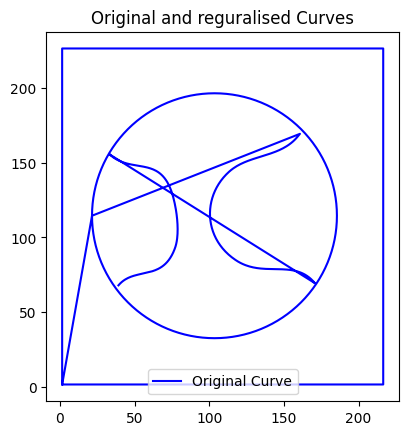

In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import LineString
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def read_points_from_csv(file_path):
    df = pd.read_csv(file_path, header=None)

    print("Data preview:\n", df.head())
    print("Columns in CSV file:", df.columns.tolist())

    x_col = df.columns[-2]
    y_col = df.columns[-1]

    points = [(row[x_col], row[y_col]) for index, row in df.iterrows()]
    return points

def identify_gaps(points, tol=1e-2):

    line = LineString(points)

    gaps = []
    for i in range(len(points) - 1):
        seg = LineString([points[i], points[i+1]])
        if not line.intersects(seg):
            gaps.append((points[i], points[i+1]))
    return gaps

# to complete the curves by generating missing segments
def complete_curves(points, gaps, num_points=10):
    completed_curves = []

    for start_point, end_point in gaps:

        x_values = [start_point[0], end_point[0]]
        y_values = [start_point[1], end_point[1]]

        interpolator = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
        new_points = [(x, interpolator(x)) for x in np.linspace(start_point[0], end_point[0], num=num_points)]

        completed_curves.extend(new_points)

    return completed_curves

def plot_curves(points, completed_curves, title="Completed Curves"):
    plt.figure()
    x, y = zip(*points)
    plt.plot(x, y, 'b-', label='Original Curve')
    if completed_curves:
        x, y = zip(*completed_curves)
        plt.plot(x, y, 'r--', label='Completed Curves')

    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()
csv_file = '/content/frag01_sol.csv'
points = read_points_from_csv(csv_file)
if len(points) < 3:
    print("Not enough points to detect shapes")
else:
    gaps = identify_gaps(points)
    completed_curves = complete_curves(points, gaps)
    plot_curves(points, completed_curves, title="Original and reguralised Curves")
